# Score vs N

In this notebook we plot the score, # of tests, # of FPs and # of FNs for several values of N. 

In [1]:
import os
os.chdir("../")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
from src import utils
from src.utils import get_fig_dim
from IPython.display import clear_output
import matplotlib.pyplot as plt

sns.set_theme(context='paper', style='ticks', font_scale=1)

In [3]:
name="score_vs_N"
width_pt = 469
palette = sns.color_palette('husl', 5)
type_dict = {
    'N' : int, 
    'false_negatives' : int,
    'false_positives' : int,
    'k' : float,
    'lambda_1' : float,
    'lambda_2' : float,
    'method' : str,
    'num_of_infected' : int,
    'num_of_tests' : int,
    'avg_group_size' : float,
    'r' : float,
    'score' : float,
    'se' : float,
    'sp' : float,
    'seed' : int
}

In [4]:
files = glob.glob("./outputs/{name}_*.json".format(name=name))

dicts = []
for fl_id, fl in enumerate(files):
    clear_output(wait=True)
    print('Reading file ' + str(fl_id+1)+'/'+str(len(files)))
    with open(fl,"r") as f:
        js = json.load(f)
        sizes = []
        for group_id in js['groups']:
            sizes.append(int(js['groups'][group_id]))

        avg_group_size = np.mean(sizes)
        
        for seed in js['seeds']:
            seed_js = js.copy()
            seed_js.pop('seeds', None)
            seed_js.pop('groups', None)    
            seed_js = seed_js | js['seeds'][seed]
            seed_js['seed']=seed
            seed_js['avg_group_size'] = avg_group_size

            dicts.append(seed_js)

input_df = pd.DataFrame(dicts)

Reading file 12/12


In [25]:
total_df = input_df.astype(type_dict) # Fix types
total_df = total_df.rename(columns={'N': 'Number of contacts', 'method': 'Method', 'avg_group_size' : 'Average pool size', 'num_of_tests': 'Number of tests'}) # Rename columns
total_df = total_df.replace({'binomial': 'Dorfman' , 'negbin': 'Algorithm 1'}) # Rename methods

In [26]:
tests_df=total_df[total_df['Number of contacts']>=20]
tests_df['Number of tests per contact'] = tests_df['Number of tests']/tests_df['Number of contacts']

<ipython-input-26-d6baf88279f7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tests_df['Number of tests per contact'] = tests_df['Number of tests']/tests_df['Number of contacts']


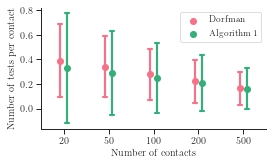

In [16]:
utils.latexify(font_size=10)

fig_height, fig_aspect = get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_height*fig_aspect,fig_height))

sns.pointplot(data=tests_df, x="Number of contacts", y="Number of tests per contact", hue="Method", palette=[palette[0]]+[palette[2]],
            ci='sd', join=False, dodge=.15, hue_order=['Dorfman', 'Algorithm 1'], capsize=.1,  ax=ax)
sns.despine()

ax.legend(title=None)
# ax.set_yscale('log')
# ax.set_yticks([1, 10, 20, 50, 100, 200])
# ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.tick_params(which='minor', left=False)

fig.tight_layout()
fig.savefig('figures/{name}_tests_per_contact.pdf'.format(name=name))

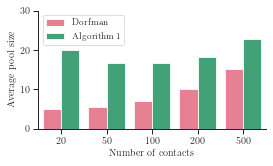

In [17]:
utils.latexify(font_size=10)

fig_height, fig_aspect = get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_height*fig_aspect,fig_height))

sns.barplot(data=tests_df, x="Number of contacts", y="Average pool size", hue="Method", ci=None, 
            palette=[palette[0]]+[palette[2]], hue_order=['Dorfman', 'Algorithm 1'])
sns.despine()

ax.legend(loc='upper left')
ax.set_ylim([0,30])

fig.tight_layout()
fig.savefig('figures/{name}_pool_size.pdf'.format(name=name))

In [46]:
perc_df = total_df.pivot(index=['lambda_1', 'lambda_2', 'se', 'sp', 'r', 'k', 'seed', 'Number of contacts'], columns='Method', values='Number of tests').reset_index()
perc_df['Perc'] = 100*(perc_df['Dorfman'] - perc_df['Algorithm 1'])/perc_df['Dorfman']
perc_df=perc_df[perc_df['Number of contacts']>=20]
perc_df
df_list = []
for N in [20, 50, 100, 200, 500]:
    temp_df = perc_df[(perc_df['Number of contacts']==N)].sort_values(by=['Perc'])
    num_of_rows_to_skip = int(0.025 * temp_df.shape[0])
    
    temp_df = temp_df.iloc[num_of_rows_to_skip:-num_of_rows_to_skip]
    df_list.append(temp_df)
    # temp_df = perc_df[(perc_df['Number of contacts']==N)]
    # print(temp_df.shape[0])
    # temp_df = perc_df[((perc_df['Number of contacts']==N) & (perc_df['Perc']<high) & (perc_df['Perc']>low))]
    # print(temp_df.shape[0])
    # df_list.append(perc_df[((perc_df['Number of contacts']==N) & (perc_df['Perc']<high) & (perc_df['Perc']>low))])

perc_df = pd.concat(df_list)

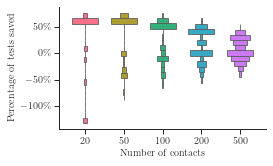

In [65]:
utils.latexify(font_size=10)

fig_height, fig_aspect = get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_height*fig_aspect,fig_height))

# Adapted from https://matplotlib.org/stable/gallery/statistics/multiple_histograms_side_by_side.html

labels = perc_df['Number of contacts'].unique()
# data_sets = [tests_df[(tests_df['Number of contacts']==N) & (tests_df['Perc'] < tests_df['Perc'].quantile(.95)) & (tests_df['Perc'] > tests_df['Perc'].quantile(.05))]['Perc'].to_numpy() for N in labels]
data_sets = [perc_df[perc_df['Number of contacts']==N]['Perc'].to_numpy() for N in labels]

hist_range = (np.min(data_sets), np.max(data_sets))
number_of_bins = 20
binned_data_sets=[]
for d in data_sets:
    hist = np.histogram(d, range=hist_range, bins=number_of_bins)[0]
    hist_max = np.max(hist)
    binned_data_sets.append(hist/hist_max)

binned_data_sets = np.array(binned_data_sets)

x_locations = np.linspace(0, len(binned_data_sets)+1, len(binned_data_sets))

i=0
for x_loc, binned_data in zip(x_locations, binned_data_sets):
    non_zero = np.nonzero(binned_data)[0]
    effective_range_ids = non_zero[0], non_zero[-1]
    effective_bins = non_zero[-1] - non_zero[0] + 1
    effective_range = hist_range[0]+non_zero[0]*(hist_range[1]-hist_range[0])/number_of_bins, \
                        hist_range[0]+non_zero[-1]*(hist_range[1]-hist_range[0])/number_of_bins

    bin_edges = np.linspace(effective_range[0], effective_range[1], effective_bins+1)
    centers = 0.5 * (bin_edges + np.roll(bin_edges, 1))[1:]
    
    heights = np.diff(bin_edges)
    # lefts = x_loc - 0.5 * binned_data
    lefts = x_loc - 0.5 * binned_data[effective_range_ids[0]:effective_range_ids[1]+1]
    ax.barh(centers, binned_data[effective_range_ids[0]:effective_range_ids[1]+1], height=heights, left=lefts, color=palette[i], edgecolor='#595959')
    i += 1

sns.despine()
ax.set_xticks(x_locations)
ax.set_xticklabels(labels)

ax.set_ylabel("Percentage of tests saved")
ax.set_xlabel("Number of contacts")
ax.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter())
# ax.set_ylim([-2, 1])
ax.set_xlim([-1, 7])

fig.tight_layout()
fig.savefig('figures/{name}_percentage.pdf'.format(name=name))

In [52]:
# utils.latexify(font_size=10)

# fig_height, fig_aspect = get_fig_dim(width_pt, fraction=0.6)
# fig, ax = plt.subplots(figsize=(fig_height*fig_aspect,fig_height))

# sns.violinplot(data=tests_df, x="Number of contacts", y="Number of tests", cut=0, split=True,
#                 hue="Method", palette=palette[:2], hue_order=['Dorfman', 'Algorithm 1'], inner=None)
# sns.despine()

# ax.legend(loc='upper left')
# ax.set_yscale('log')
# ax.set_yticks([1, 5, 10, 20, 50, 100, 200, 500])
# ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax.tick_params(which='minor', left=False)

# fig.tight_layout()
# fig.savefig('figures/{name}_tests_log_dist.pdf'.format(name=name))